In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
keras = tf.keras

In [2]:
def plot_series(time,series,start = 0,end = None,format = "-",label =None):
    plt.plot(time[start:end],series[start:end],format,label = label)
    plt.xlabel("Time")
    plt.ylabel("Values")
    if label:
        plt.legend(fontsize = 14)
    plt.grid(True)
    
def trend(time,slope = 0):
    return time * slope

def season_pattern(season_time):
    return np.where(season_time < 0.4,
                   np.cos(2*season_time*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude = 1,phase = 0):
    season_time = ((time + phase)%period)/period
    return amplitude * season_pattern(season_time)

def white_noise(time,noise_level,seed = 0):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

In [3]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift = window_size,drop_remainder = True)
    ds = ds.flat_map(lambda w:w.batch(window_size+1))
    ds = ds.map(lambda w:(w[:-1],w[1:]))
    return ds.batch(1).prefetch(1)

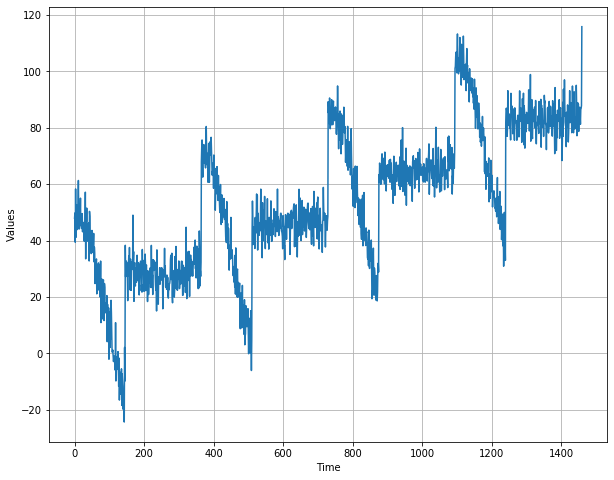

In [4]:
time = np.arange(4*365+1)

slope = 0.05
baseline = 10
amplitude = 40

series = baseline + trend(time,slope) + seasonality(time,period = 365,amplitude = amplitude)

noise_level = 5
noise = white_noise(time,noise_level,seed = 2)

series += noise

plt.figure(figsize=(10,8))
plot_series(time,series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
class ResetStateCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

## LSTM Forecasting

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train,window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences = True,stateful = True,
                     batch_input_shape = [1,None,1]),
    keras.layers.LSTM(100,return_sequences =True,stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20)
)

reset_states = ResetStateCallback()

optimizer = keras.optimizers.SGD(lr = 1e-8,momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

history = model.fit(train_set,epochs = 100,
                   callbacks = [lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 5s 156ms/step - loss: 90.4838 - mae: 90.9836
Epoch 2/100
33/33 [==============================] - 1s 31ms/step - loss: 83.4801 - mae: 83.9801
Epoch 3/100
33/33 [==============================] - 1s 28ms/step - loss: 75.0923 - mae: 75.5919
Epoch 4/100
33/33 [==============================] - 1s 27ms/step - loss: 65.6854 - mae: 66.1854
Epoch 5/100
33/33 [==============================] - 1s 28ms/step - loss: 55.1780 - mae: 55.6780
Epoch 6/100
33/33 [==============================] - 1s 35ms/step - loss: 43.5083 - mae: 44.0082
Epoch 7/100
33/33 [==============================] - 1s 33ms/step - loss: 30.6557 - mae: 31.1556
Epoch 8/100
33/33 [==============================] - 1s 29ms/step - loss: 17.1944 - mae: 17.6907
Epoch 9/100
33/33 [==============================] - 1s 27ms/step - loss: 9.9972 - mae: 10.4848
Epoch 10/100
33/33 [==============================] - 1s 27ms/step - loss: 9.9962 - mae: 10.4867
Epoch 11/100
33/33 [==========

33/33 [==============================] - 1s 26ms/step - loss: 21.6784 - mae: 22.1741
Epoch 86/100
33/33 [==============================] - 1s 26ms/step - loss: 13.7149 - mae: 14.2057
Epoch 87/100
33/33 [==============================] - 1s 28ms/step - loss: 18.3169 - mae: 18.8109
Epoch 88/100
33/33 [==============================] - 1s 26ms/step - loss: 32.1032 - mae: 32.6000
Epoch 89/100
33/33 [==============================] - 1s 26ms/step - loss: 28.4234 - mae: 28.9193
Epoch 90/100
33/33 [==============================] - 1s 26ms/step - loss: 19.6025 - mae: 20.0961
Epoch 91/100
33/33 [==============================] - 1s 26ms/step - loss: 24.4277 - mae: 24.9240
Epoch 92/100
33/33 [==============================] - 1s 27ms/step - loss: 27.0149 - mae: 27.5114
Epoch 93/100
33/33 [==============================] - 1s 27ms/step - loss: 40.5512 - mae: 41.0499
Epoch 94/100
33/33 [==============================] - 1s 27ms/step - loss: 38.8081 - mae: 39.3046
Epoch 95/100
33/33 [=============

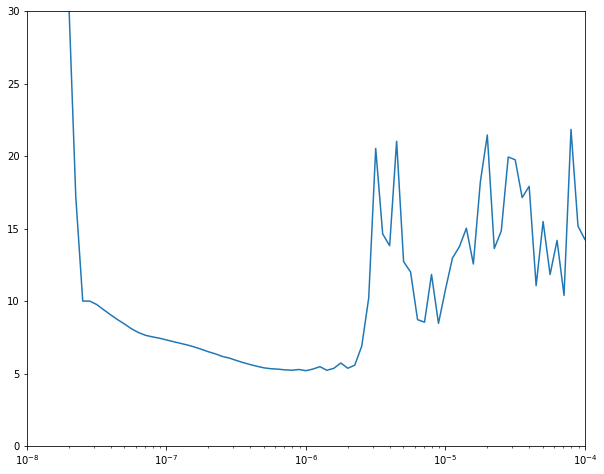

In [8]:
plt.figure(figsize = (10,8))
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])
plt.show()

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train,window_size)
valid_set = sequential_window_dataset(x_valid,window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences = True,stateful = True,
                     batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences = True,stateful = True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200.0)
])

optimizer = keras.optimizers.SGD(lr = 5e-6 , momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience = 50)

reset_states = ResetStateCallback()

model_checkpoint = keras.callbacks.ModelCheckpoint("LSTM_checkpoint.h5",
                                                  save_best_only = True)

model.fit(train_set,epochs = 500,
         validation_data = valid_set,
         callbacks = [early_stopping,reset_states,model_checkpoint])

Epoch 1/500
33/33 [==============================] - 5s 164ms/step - loss: 32.3209 - mae: 32.8197 - val_loss: 37.0910 - val_mae: 37.5910
Epoch 2/500
33/33 [==============================] - 1s 38ms/step - loss: 20.0960 - mae: 20.5918 - val_loss: 23.8816 - val_mae: 24.3816
Epoch 3/500
33/33 [==============================] - 1s 33ms/step - loss: 11.2316 - mae: 11.7220 - val_loss: 7.6229 - val_mae: 8.1131
Epoch 4/500
33/33 [==============================] - 1s 33ms/step - loss: 7.8483 - mae: 8.3360 - val_loss: 6.7563 - val_mae: 7.2410
Epoch 5/500
33/33 [==============================] - 1s 34ms/step - loss: 8.8747 - mae: 9.3642 - val_loss: 13.4909 - val_mae: 13.9868
Epoch 6/500
33/33 [==============================] - 1s 35ms/step - loss: 7.7275 - mae: 8.2129 - val_loss: 6.5569 - val_mae: 7.0425
Epoch 7/500
33/33 [==============================] - 1s 31ms/step - loss: 8.4073 - mae: 8.8971 - val_loss: 6.7179 - val_mae: 7.2075
Epoch 8/500
33/33 [==============================] - 1s 31ms/st

33/33 [==============================] - 1s 34ms/step - loss: 10.6057 - mae: 11.0987 - val_loss: 9.9525 - val_mae: 10.4433
Epoch 63/500
33/33 [==============================] - 1s 34ms/step - loss: 6.9152 - mae: 7.4014 - val_loss: 6.6101 - val_mae: 7.0995
Epoch 64/500
33/33 [==============================] - 1s 34ms/step - loss: 6.0876 - mae: 6.5695 - val_loss: 7.0991 - val_mae: 7.5854
Epoch 65/500
33/33 [==============================] - 1s 32ms/step - loss: 5.5808 - mae: 6.0618 - val_loss: 6.2074 - val_mae: 6.6908
Epoch 66/500
33/33 [==============================] - 1s 38ms/step - loss: 5.5872 - mae: 6.0676 - val_loss: 7.5454 - val_mae: 8.0324
Epoch 67/500
33/33 [==============================] - 1s 30ms/step - loss: 5.1978 - mae: 5.6786 - val_loss: 5.8831 - val_mae: 6.3645
Epoch 68/500
33/33 [==============================] - 1s 34ms/step - loss: 6.3241 - mae: 6.8041 - val_loss: 5.6617 - val_mae: 6.1357
Epoch 69/500
33/33 [==============================] - 1s 34ms/step - loss: 6.75

In [15]:
model = keras.models.load_model('LSTM_checkpoint.h5')

In [16]:
rnn_forecast = model.predict(series[np.newaxis,:,np.newaxis])
rnn_forecast = rnn_forecast[0,split_time-1: -1,0]

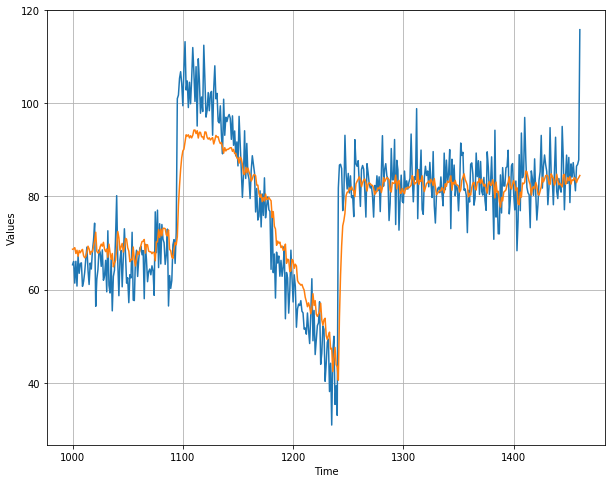

In [17]:
plt.figure(figsize=(10,8))
plot_series(time_valid,x_valid)
plot_series(time_valid,rnn_forecast)
plt.show()

In [18]:
keras.metrics.mean_absolute_error(x_valid,rnn_forecast).numpy()

5.504519